# Using the DESI AGN / QSO Value-Added Catalog
##### Authors: (Please add names) B. Canning, S. Juneau, M. Mezcua, R. Pucha, R. Alfarsy, S. Behera, G. Suidek, B. Floyd, S. Srinivas,  

This is an example notebook which demonstrates use cases fo the DESI AGN/QSO value-added catalog (VAC).

**TO DO:** add info here about what is needed to run the notebook? GitClone some repo and/or can we turn into a standalone? (NOTE: the call to `from set_agn_masksDESI import get_agn_maskbits` implies that users have cloned the full desigaldev repo so maybe we need to re-think this)




### 1) First let's import some stuff!

In [23]:
# Numpy
import numpy as np
# Plotting stuff and suppressing boring warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

# Get the GQP code
import sys
# Set the path where the py scripts are
sys.path.append("../py/")
import set_agn_masksDESI
from set_agn_masksDESI import get_agn_maskbits

import fitsio

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table #, join, Column
from astropy.io import fits

# TO DO: simplify/clean this?
settings = {
    'font.size':12,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True,
    'axes.labelsize':18
}
#    'xlabel.fontsize':18,
#    'ylabel.fontsize':18
#    }

plt.rcParams.update(**settings)

### 2) Now we are ready to open the catalog.

The public location of the catalog is:


The internal GQP drive at NERSC is

        /global/cfs/cdirs/desi/science/gqp/

From there we can find the 'agncatalog' folder and follow the link on to 'catalog'

In [2]:
def return_catdir(location='nersc'):

    dl_path = '~/data/DESI/science/gqp/agncatalog/catalog/'
    nersc_path = '/global/cfs/cdirs/desi/science/gqp/agncatalog/dr1/v1.0/'
    if location=='datalab':
        return(dl_path)
    else:
        return(nersc_path)  #default

In [3]:
catdir = return_catdir(location='nersc')

# Open the catalog
agn_hdul = fits.open(f'{catdir}agnqso_desi.fits', format='fits')
agn_hdul.info()

Filename: /global/cfs/cdirs/desi/science/gqp/agncatalog/dr1/v1.0/agnqso_desi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  AGNCAT        1 BinTableHDU     89   17995599R x 36C   [K, 7A, 6A, J, D, D, K, 6A, K, K, K, J, D, D, K, D, D, D, I, E, L, L, L, K, K, K, K, K, K, K, K, K, K, K, K, K]   
  2  AUXDATA       1 BinTableHDU    182   17995599R x 58C   [K, 7A, 6A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


As we can see the data is stored in extension number 1.

In [4]:
%%time
# Load the catalog into Astropy tables
T = Table(agn_hdul[1].data)
T2 = Table(agn_hdul[2].data)

CPU times: user 48.7 s, sys: 14.4 s, total: 1min 3s
Wall time: 1min 5s


Let's print the columns in this catalog.

In [5]:
# What are the columns?
T.columns

<TableColumns names=('TARGETID','SURVEY','PROGRAM','HEALPIX','Z','ZERR','ZWARN','SPECTYPE','AGN_MASKBITS','OPT_UV_TYPE','IR_TYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','LS_ID','MIN_MJD','MEAN_MJD','MAX_MJD','COADD_NUMEXP','COADD_EXPTIME','SV_PRIMARY','MAIN_PRIMARY','ZCAT_PRIMARY','DESI_TARGET','SCND_TARGET','BGS_TARGET','CMX_TARGET','SV1_DESI_TARGET','SV2_DESI_TARGET','SV3_DESI_TARGET','SV1_BGS_TARGET','SV2_BGS_TARGET','SV3_BGS_TARGET','SV1_SCND_TARGET','SV2_SCND_TARGET','SV3_SCND_TARGET')>

In particular we acess information about the AGN and QSO diagnostics via the AGN_MASKBITS and OPT_UV_TYPE columns. We can read the definitions for the bitmasks in the yaml file.

In [6]:
AGN_MASKBITS, OPT_UV_TYPE, IR_TYPE = get_agn_maskbits('../py/agnmask.yaml')

These are the bitmask which contain the infomation. The format of these bitmasks is:    

    - [name of the target bit,  bit value,  "description as a string"]
    
For example:

    - [NII_SY,           8, "NII BPT Seyfert"]
    
This means the name of the target bit is NII_SY, its bit value is 2$^{8}$ and its description is a Seyfert object according to the NII BPT.

So let's see what the bitmasks look like.

In [7]:
print(AGN_MASKBITS)

AGN_MASKBITS:
  - [AGN_ANY,          0, "any AGN classification is set"]
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]
  - [QN_BGS,           5, "Quasar Net reclassifies BGS target as a QSO"]
  - [QN_ELG,           6, "Quasar Net reclassifies ELG target as a QSO"]
  - [QN_VAR_WISE,      7, "Quasar Net reclassifies VAR_WISE_QSO target as a QSO"]
  - [BPT_ANY_SY,      10, "At least one BPT diagnostic indicates SEYFERT (robust AGN)"]
  - [BPT_ANY_AGN,     11, "At least one BPT diagnostic indicates SEYFERT, LINER or COMPOSITE"]
  - [BROAD_LINE,      12, "Lines with FWHM >=1200 km/s in Halpha, Hbeta, MgII and/or CIV line"]
  - [OPT_OTHER_AGN,   13, "Rest frame optical emission lines diagnostic not BPT (4000-10000 ang) indicate AGN"]
  - [UV,              14, "Re

In [8]:
print(OPT_UV_TYPE)

OPT_UV_TYPE:
  - [NII_BPT,          0, "NII BPT diagnostic is available (update_AGNTYPE_NIIBPT)"]
  - [NII_SF,           1, "NII BPT Star-forming (update_AGNTYPE_NIIBPT)"]
  - [NII_COMP,         2, "NII BPT Composite (update_AGNTYPE_NIIBPT)"]
  - [NII_SY,           3, "NII BPT Seyfert (update_AGNTYPE_NIIBPT)"]
  - [NII_LINER,        4, "NII BPT LINER (update_AGNTYPE_NIIBPT)"]
  - [SII_BPT,          5, "SII BPT diagnostic is available (update_AGNTYPE_SIIBPT)"]
  - [SII_SF,           6, "SII BPT Star-forming (update_AGNTYPE_SIIBPT)"]
  - [SII_SY,           7, "SII BPT Seyfert (update_AGNTYPE_SIIBPT)"]
  - [SII_LINER,        8, "SII BPT LINER (update_AGNTYPE_SIIBPT)"]
  - [OI_BPT,           9, "OI BPT diagnostic is available (update_AGNTYPE_OIBPT)"]
  - [OI_SF,           10, "OI BPT Star-forming (update_AGNTYPE_OIBPT)"]
  - [OI_SY,           11, "OI BPT Seyfert (update_AGNTYPE_OIBPT)"]
  - [OI_LINER,        12, "OI BPT LINER (update_AGNTYPE_OIBPT)"]
  - [WHAN,            13, "WHAN is avai

## 1) How to find the number of certain classes

### Examples: NII BPT LINER and Star-forming (SF) galaxies

In [9]:
is_nii_liner = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_LINER != 0)
len(T[is_nii_liner])

45211

In [10]:
is_nii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
len(T[is_nii_sf])

1809470

## 2) How to plot distributions

### Compare redshift distributions of different AGN classes

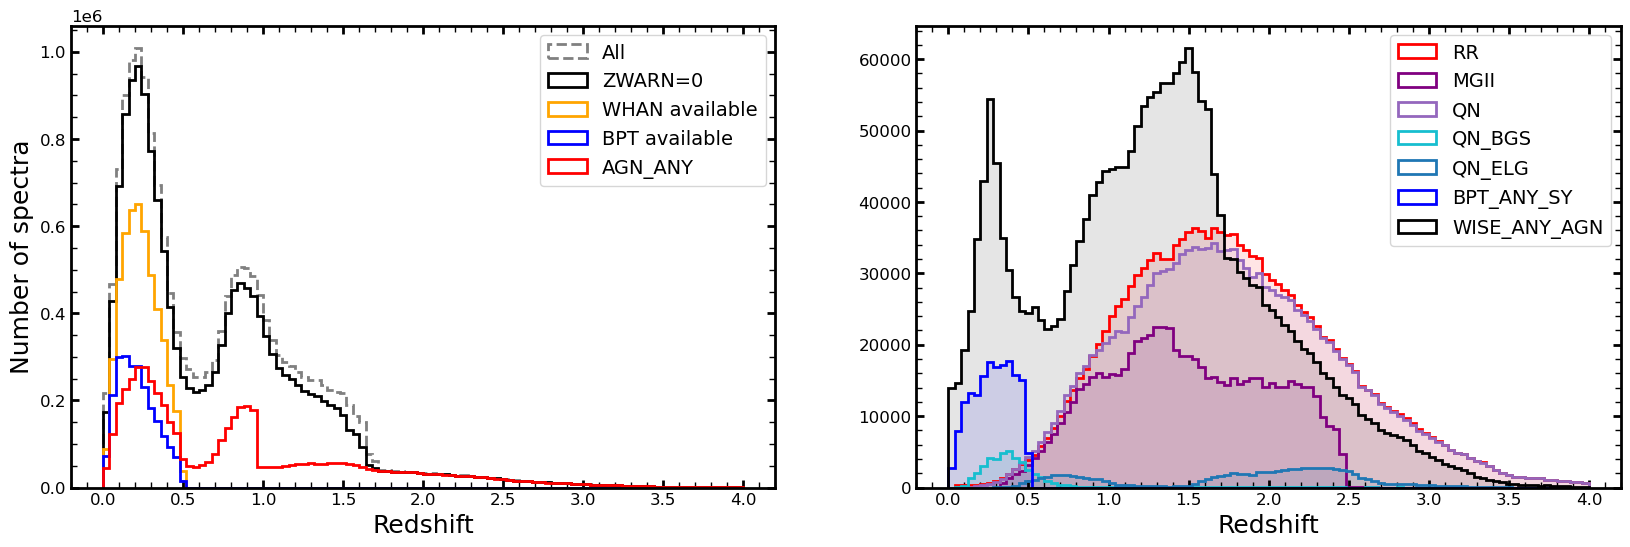

In [11]:
#agntypes = ['RR', 'MGII', 'QN', 'QN_BGS', 'QN_ELG', 'BPT_ANY_SY', 'OPT_OTHER_AGN', 'WISE_ANY_AGN']
#colors = ['red', 'purple', 'tab:purple', 'tab:cyan', 'tab:blue', 'blue', 'green', 'black']

# TO DO: add QSO in labels; 

agntypes = ['QSO (RR)', 'MGII', 'QN', 'QN_BGS', 'QN_ELG', 'BPT_ANY_SY', 'WISE_ANY_AGN']
colors = ['red', 'purple', 'tab:purple', 'tab:cyan', 'tab:blue', 'blue', 'black']

agnany = (T['AGN_MASKBITS'] & AGN_MASKBITS['AGN_ANY'] !=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), sharex=True)

# Left-hand panel: full catalog + only secure redshifts
ax1.hist(T['Z'],bins=100,range=(0,4), histtype='step', lw=2, color='gray', ls='--', label='All')
ax1.hist(T['Z'][T['ZWARN']==0],bins=100,range=(0,4), histtype='step', lw=2, color='k', label='ZWARN=0')
ax1.hist(T['Z'][(T['ZWARN']==0)&(T['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN != 0)],bins=100,range=(0,4), histtype='step', lw=2, color='orange', label='WHAN available')
ax1.hist(T['Z'][(T['ZWARN']==0)&(T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_BPT != 0)],bins=100,range=(0,4), histtype='step', lw=2, color='b', label='BPT available')
#ax1.hist(T['Z'][agnany&(T['ZWARN']==0)],bins=100,range=(0,4), histtype='step', lw=2, color='red', label='AGN_ANY')
# TO DO: replace AGN_ANY with WISE_available

# Right-hand panel: selected classes of AGN/QSO
for i, agn in enumerate(agntypes):
    sel = (T['AGN_MASKBITS'] & AGN_MASKBITS[agn] != 0)
    col = colors[i]
    ax2.hist(T['Z'][sel],bins=100,range=(0,4), alpha=0.1, color=col)
    ax2.hist(T['Z'][sel],bins=100,range=(0,4), label=agn, histtype='step', lw=2, color=col)

# Axis labels
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of spectra')
ax2.set_xlabel('Redshift')

# Legends
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)
plt.show()

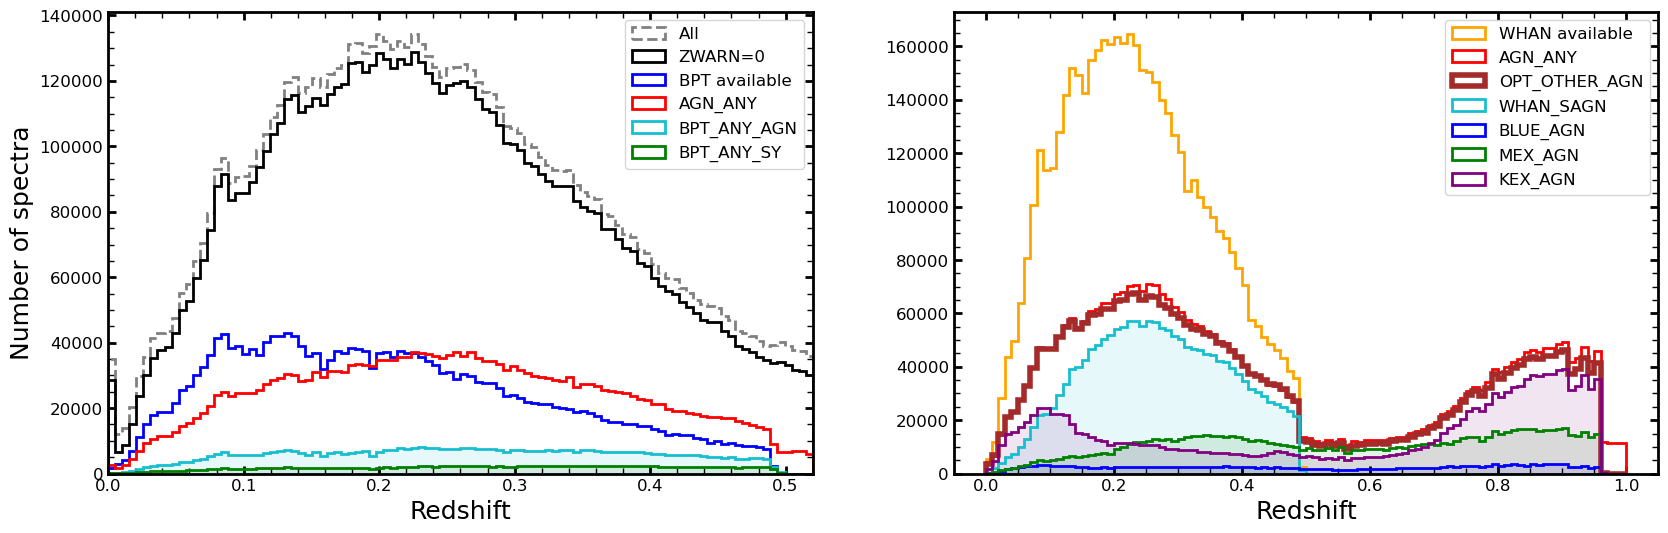

In [12]:
## To Do: add a second panel to showcase some "OTHER_OPT_UV" diagnostics so extending to z~1 or z~1.5 as appropriate

## Focusin on low-z, BPT
agntypes = ['BPT_ANY_AGN', 'BPT_ANY_SY']
colors = ['tab:cyan', 'green']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), sharex=False)

zr1 = (0,0.52)

# Left-hand panel: full catalog + only secure redshifts
ax1.hist(T['Z'],bins=100,range=zr1, histtype='step', lw=2, color='gray', ls='--', label='All')
ax1.hist(T['Z'][T['ZWARN']==0],bins=100,range=zr1, histtype='step', lw=2, color='k', label='ZWARN=0')

# Available
ax1.hist(T['Z'][(T['ZWARN']==0)&(T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_BPT != 0)],bins=100,range=zr1, histtype='step', lw=2, color='b', label='BPT available')

## AGN ANY
ax1.hist(T['Z'][agnany&(T['ZWARN']==0)],bins=100,range=zr1, histtype='step', lw=2, color='red', label='AGN_ANY')

#selected classes of AGN/QSO
for i, agn in enumerate(agntypes):
    sel = (T['AGN_MASKBITS'] & AGN_MASKBITS[agn] != 0)
    col = colors[i]
    ax1.hist(T['Z'][sel],bins=100,range=zr1, alpha=0.1, color=col)
    ax1.hist(T['Z'][sel],bins=100,range=zr1, label=agn, histtype='step', lw=2, color=col)

ax1.set_xlim(zr1)

## Right-hand panel
zr2 = (0,1.)
optuv_types = ['WHAN_SAGN', 'BLUE_AGN', 'MEX_AGN', 'KEX_AGN']
colors = ['tab:cyan', 'blue', 'green', 'purple']

# full catalog + only secure redshifts
#ax2.hist(T['Z'],bins=100,range=zr2, histtype='step', lw=2, color='gray', ls='--', label='All')
#ax2.hist(T['Z'][T['ZWARN']==0],bins=100,range=zr2, histtype='step', lw=2, color='k', label='ZWARN=0')

# Available
ax2.hist(T['Z'][(T['ZWARN']==0)&(T['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN != 0)],bins=100,range=zr2, histtype='step', lw=2, color='orange', label='WHAN available')

## AGN ANY
ax2.hist(T['Z'][agnany&(T['ZWARN']==0)],bins=100,range=zr2, histtype='step', lw=2, color='red', label='AGN_ANY')

## OPT_OTHER_AGN (seems to have a bug as it only picked up WHAN and not MEx, Blue, KEx)
## Also KEx is missing entirely??
sel = (T['AGN_MASKBITS'] & AGN_MASKBITS['OPT_OTHER_AGN'] != 0)
ax2.hist(T['Z'][sel],bins=100,range=zr2, histtype='step', lw=4, color='brown', label='OPT_OTHER_AGN')
#&(T['ZWARN']==0)

#selected classes of AGN/QSO
for i, agn in enumerate(optuv_types):
    sel = (T['OPT_UV_TYPE'] & OPT_UV_TYPE[agn] != 0)
    col = colors[i]
    ax2.hist(T['Z'][sel],bins=100,range=zr2, alpha=0.1, color=col)
    ax2.hist(T['Z'][sel],bins=100,range=zr2, label=agn, histtype='step', lw=2, color=col)

# Legends
ax1.legend()
ax2.legend()

# Axis labels
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of spectra')
ax2.set_xlabel('Redshift')

plt.show()

## 3) Let's try to filter by some BPT AGN diagnostics and plot the result.

Let's begin with the BPT plots.

To plot the BPT plots we'll need to find the logarithm of the ratios needed for the x and y axes.

In [14]:
xx_bptnii = np.log10(T2['NII_6584_FLUX']/T2['HALPHA_FLUX'])
xx_bptsii = np.log10((T2['SII_6716_FLUX']+T2['SII_6731_FLUX'])/T2['HALPHA_FLUX'])
xx_bptoi = np.log10(T2['OI_6300_FLUX']/T2['HALPHA_FLUX'])
yy_bpt = np.log10(T2['OIII_5007_FLUX']/T2['HBETA_FLUX'])

Now let's use our bitmask to filter these vectors. 

As an example let's think about how we might filter the NII BPT star-forming objects. In the AGN_TYPE bitmask the star-forming objects are defined with:

    AGN_TYPE:
    ...
    - [NII_SF,           6, "NII BPT Star-forming"]
    ...
    
Accessing the OPT_UV_TYPE column of our table, T, is done through:

    T['OPT_UV_TYPE']
    
This is where the numeric value associated with our binary number is stored. 
    
We filter a bitmask by identfying a bit that is flipped to a 1. 2^0=1, 2^1=10, 2^2=100, 2^3=1000...

So for example if T['OPT_UV_TYPE'] is 11 then the binary represenation would be 1011 formed from 11 = 8+2+1 = 2^3+2^1+2^0 = 1000 + 10 + 1. 

In this case for the first 4 bitvalues we would find:

for bitnumber of 11

    is 2^0 true = 1
    is 2^1 true = 1
    is 2^2 true = 0
    is 2^3 true = 1
    
in pseudo code we could express this as

    is_0 = ( 11 & 2^0 != 0)
    is_1 = ( 11 & 2^1 != 0)
    is_2 = ( 11 & 2^2 != 0)
    is_3 = ( 11 & 2^3 != 0)
    
Now let's return to think about the case of is our 'OPT_UV_TYPE' diagnostic NII_SF. We could write this as:    

    is_nii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
    


Using this logic, let's try filtering and printing the NII, SII and OI BPT plot.

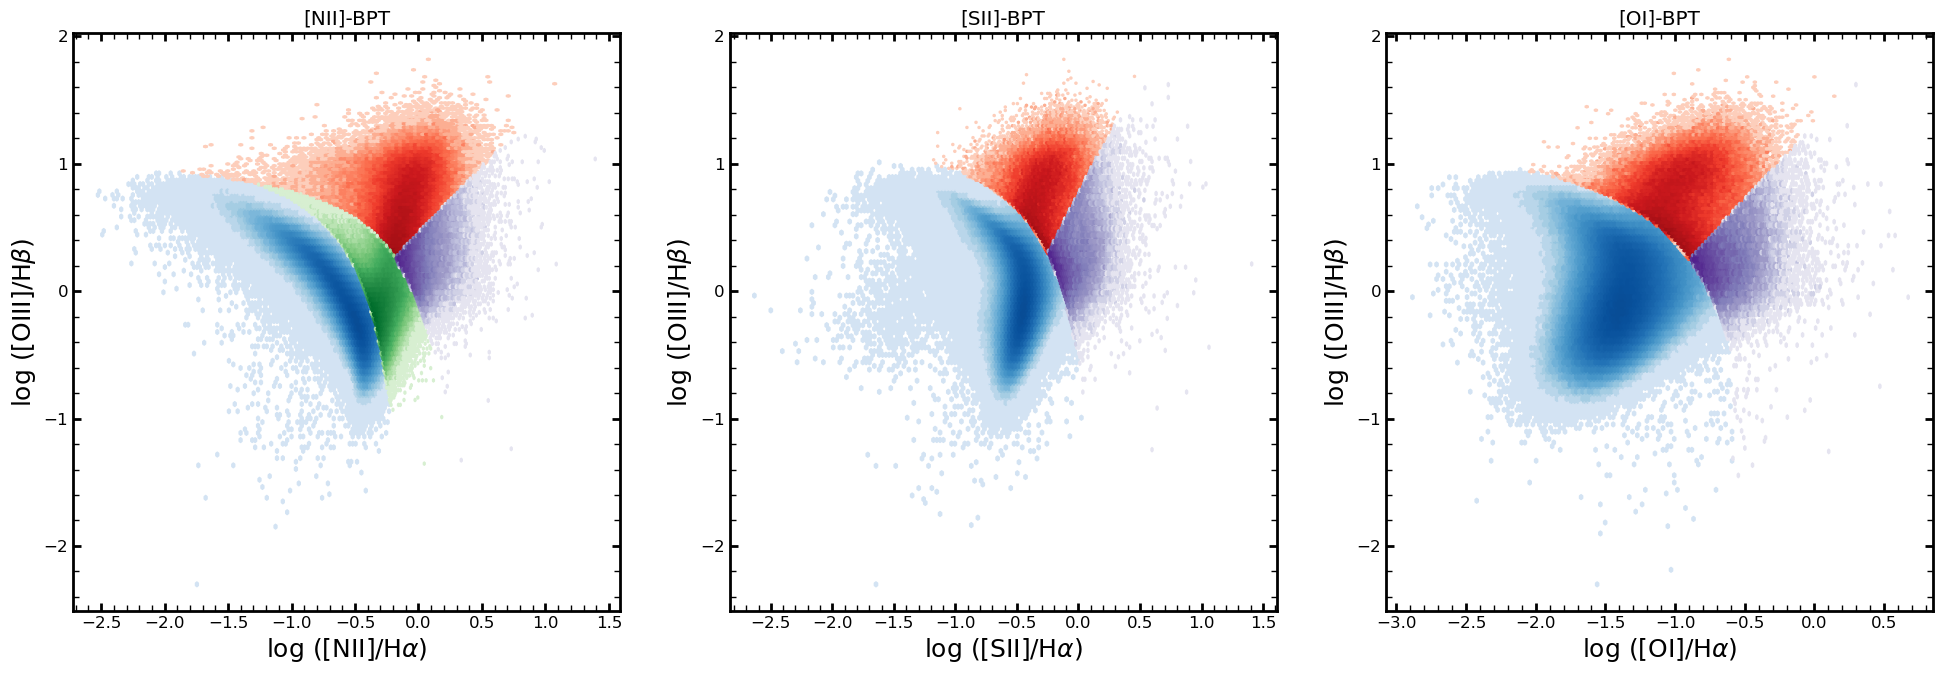

In [36]:
is_nii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
is_nii_sy = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SY != 0)
is_nii_lin = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_LINER != 0)
is_nii_comp = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_COMP != 0)

is_sii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_SF != 0)
is_sii_sy = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_SY != 0)
is_sii_lin = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_LINER != 0)

is_oi_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_SF != 0)
is_oi_sy = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_SY != 0)
is_oi_lin = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_LINER != 0)

###### TO DO ########
## Fix plotting range to more reasonable values 
##
## SJ: add legends!! with Star-Forming, Composite, etc.
## make axes font size larger
## 


## Parameters for all plots
norm_min, norm_max = 0.3, 200

## Initialize figure
plt.figure(figsize = (24,7.5))

plt.subplot2grid((1,3), (0,0))
plt.title('[NII]-BPT')
plt.hexbin(xx_bptnii[is_nii_sf], yy_bpt[is_nii_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Blues')
plt.hexbin(xx_bptnii[is_nii_sy], yy_bpt[is_nii_sy], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Reds')
plt.hexbin(xx_bptnii[is_nii_comp], yy_bpt[is_nii_comp], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Greens')
plt.hexbin(xx_bptnii[is_nii_lin], yy_bpt[is_nii_lin], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Purples')
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.subplot2grid((1,3), (0,1))
plt.title('[SII]-BPT')
plt.hexbin(xx_bptsii[is_sii_sf], yy_bpt[is_sii_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Blues')
plt.hexbin(xx_bptsii[is_sii_sy], yy_bpt[is_sii_sy], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Reds')
plt.hexbin(xx_bptsii[is_sii_lin], yy_bpt[is_sii_lin], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Purples')
plt.xlabel('log ([SII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.subplot2grid((1,3), (0,2))
plt.title('[OI]-BPT')
plt.hexbin(xx_bptoi[is_oi_sf], yy_bpt[is_oi_sf], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Blues')
plt.hexbin(xx_bptoi[is_oi_sy], yy_bpt[is_oi_sy], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Reds')
plt.hexbin(xx_bptoi[is_oi_lin], yy_bpt[is_oi_lin], bins=100, norm=LogNorm(norm_min, norm_max), cmap='Purples')
plt.xlabel('log ([OI]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.show()

### 4) Let's plot all the diagnostics we have

The NII, SII and OI BPT are plotted above. The other optical and UV diagnostics are:

1. HeII_BPT
2. WHAN
3. Blue diagram
4. NeV
5. MEx
6. KEx

Let's try these in order below.

#### 1) HeII BPT diagnostic

TO DO: Check with Ben and replace the scatter plot with hexbin

Consistent color scheme with the BPT: SF (blue), AGN (red), weak AGN (purple), composites/intermediate (green)

In [19]:
xx_bptnii = np.log10(T2['NII_6584_FLUX']/T2['HALPHA_FLUX'])
yy_bptheii = np.log10(T2['HEII_4686_FLUX']/T2['HBETA_FLUX'])

In [20]:
is_heii = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.HEII_BPT != 0)
is_heii_sf = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.HEII_SF != 0)
is_heii_agn = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.HEII_AGN != 0)

In [21]:
# log10(flux_heii_4685/flux_hbeta)=-1.22+1/(8.92*log10(flux_nii_6583/flux_halpha)+1.32)
x_heiiline = np.linspace(-3,-1.32/8.92,70)
y_heiiline = -1.22+1/(8.92*x_heiiline+1.32)

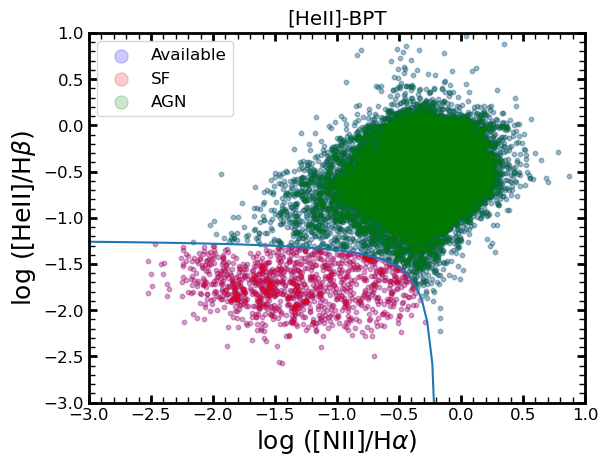

In [22]:
plt.title('[HeII]-BPT')
plt.scatter(xx_bptnii[is_heii], yy_bptheii[is_heii], color = 'b', s = 10, label='Available', alpha=0.2)
plt.scatter(xx_bptnii[is_heii_sf], yy_bptheii[is_heii_sf], color = 'r', s = 10, label='SF', alpha=0.2)
plt.scatter(xx_bptnii[is_heii_agn], yy_bptheii[is_heii_agn], color = 'g', s = 10, label='AGN', alpha=0.2)
plt.plot(x_heiiline, y_heiiline)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([HeII]/H$\\beta$)')
plt.xlim(-3, 1)
plt.ylim(-3, 1)
plt.legend(markerscale=3)
plt.show()

#### 2) WHAN

TO DO: Sai to replace scatter with hexbin

Consistent color scheme with the BPT: SF (blue), AGN (red), weak AGN (purple), composites/intermediate (green)

Spell out the classes in the legend

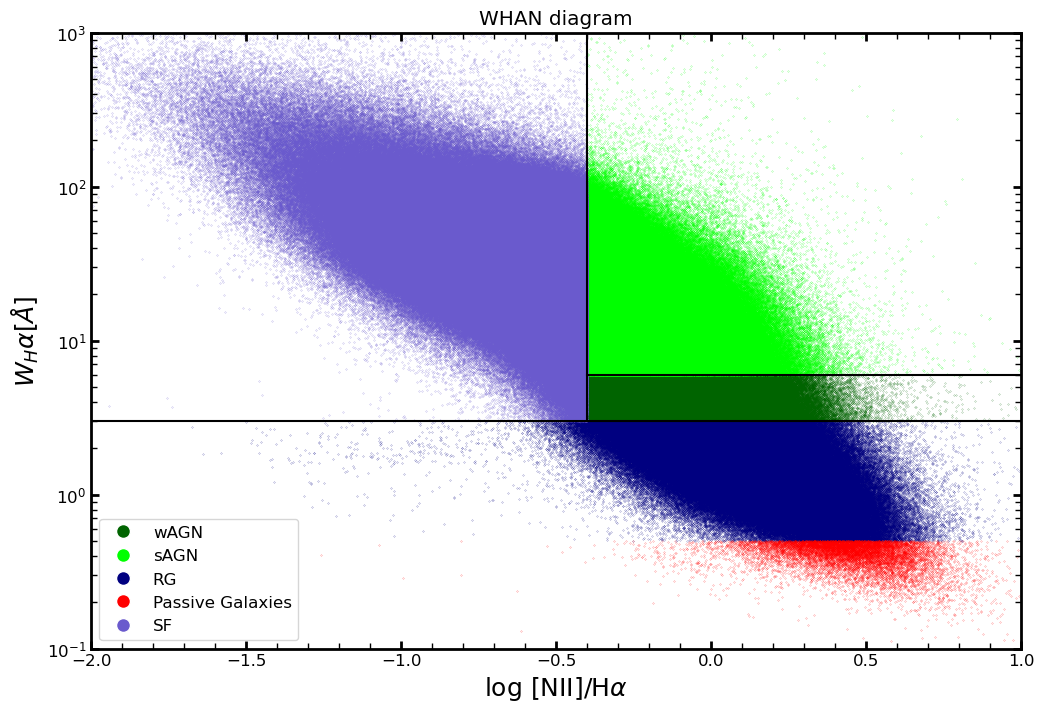

In [24]:

#we define the masks required for the classification of AGNs for the WHAN BPT diagram
is_whan_av = (T['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN !=0)
#creating the subcatalog for the objects for which the WHAN is available
T_WHAN = T[is_whan_av]
T2_WHAN = T2[is_whan_av]
xx_bptwhan=np.log10((T2_WHAN['NII_6584_FLUX']/T2_WHAN['HALPHA_FLUX'])) 
yy_Wha = T2_WHAN['HALPHA_EW'] #getting the width of H-alpha line
#creating the masks for different WHAN objects
is_whan_sf = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_SF !=0)  #Star forming galaxies mask
is_whan_sagn = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_SAGN != 0) #strong AGN mask
is_whan_wagn = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_WAGN != 0) #weak AGN mask
is_whan_ret = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_RET !=0) #retired galaxies mask
is_whan_pass = (T_WHAN['OPT_UV_TYPE'] & OPT_UV_TYPE.WHAN_PASS !=0) #passive galaxies mask
size = 0.02 #modify according to the choice of points in the scatter plot
#initializing the figure properties
plt.figure(figsize=(12,8))
plt.title('WHAN diagram')

#creating the WHAN BPT diagram
plt.scatter(xx_bptwhan[is_whan_wagn], yy_Wha[is_whan_wagn], color='darkgreen', s=size, label='wAGN')
plt.scatter(xx_bptwhan[is_whan_sagn], yy_Wha[is_whan_sagn], color = 'lime', s=size, label='sAGN')
plt.scatter(xx_bptwhan[is_whan_ret], yy_Wha[is_whan_ret], color= 'navy', s=size, label='RG')
plt.scatter(xx_bptwhan[is_whan_pass], yy_Wha[is_whan_pass], color = 'r', s=size, label='Passive Galaxies')
plt.scatter(xx_bptwhan[is_whan_sf], yy_Wha[is_whan_sf], color = 'slateblue', s=size, label='SF')
#defining the theoretical cuts for different objects
x_cutoff_SF = -0.4 #star forming WHAN cutoff criteria
plt.plot([x_cutoff_SF, x_cutoff_SF], [3, 10**3], color='black')
y_cutoff_sAGN = 6 #strong AGN WHAN cutoff criteria
plt.plot([-0.4, 1], [y_cutoff_sAGN, y_cutoff_sAGN], color='black')
plt.axhline(y=3, color='black') #criteria for the retired galaxies, also referred to as the fake AGNs
plt.xlabel('log [NII]/H$\\alpha$') 
plt.ylabel('$W_H\\alpha [{\AA}]$')
plt.yscale('log')
#defining the limits of the plot
plt.xlim(-2, 1)
plt.ylim(0.1, 10**3)
#defining the legends of the scatter plot separately for better visualization
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='wAGN', markerfacecolor='darkgreen', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='sAGN', markerfacecolor='lime', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='RG', markerfacecolor='navy', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Passive Galaxies', markerfacecolor='r', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='SF', markerfacecolor='slateblue', markersize=10)
]
# Customize legend with larger markers
plt.legend(handles=legend_elements, loc='best')

#### 3) Blue diagram

TO DO: Sai & Ben : replace scatter with hexbin, add brief explanation and references here in the text box.

make color scheme consistent: SF (blue), AGN (red), weak AGN (purple), composites/intermediate (green)

spell out the classes in the legend + make larger symbols


In [30]:
# Create masks for each of the Blue diagnostic subsets
blue_av_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE != 0 
blue_agn_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_AGN != 0
blue_slc_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_SLC != 0
blue_liner_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_LINER != 0
blue_sf_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_SF != 0
blue_sfagn_mask = T['OPT_UV_TYPE'] & OPT_UV_TYPE.BLUE_SFAGN != 0

In [31]:
# Set our plotting data axes 
xx_blue = np.log10((T2['OII_3726_EW']+T2['OII_3729_EW']) / T2['HBETA_EW'])
yy_blue = np.log10(T2['OIII_5007_FLUX'] / T2['HBETA_FLUX'])

In [32]:
# lines
xx_blue_main_lines = np.linspace(-2., 0.9, num=200)
xx_blue_slc_lines = np.linspace(0.09, 1.06)
blue_main_line = 0.11 / (xx_blue_main_lines - 0.92) + 0.85
blue_eq3a = -(xx_blue_slc_lines - 1.)**2 - 0.1 * xx_blue_slc_lines + 0.25
blue_eq3b = (xx_blue_slc_lines - 0.2)**2 - 0.6

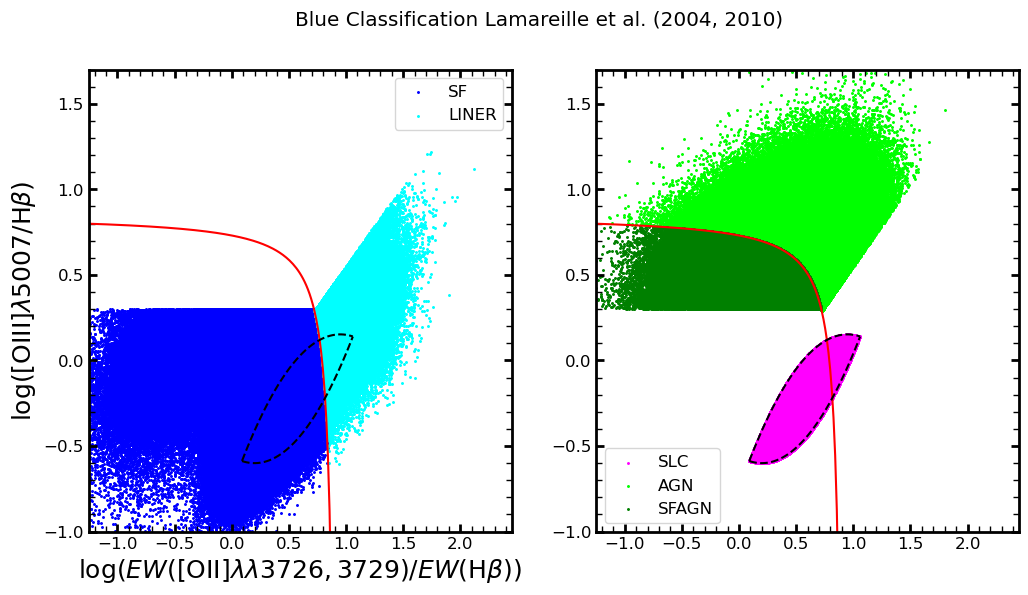

In [34]:
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(12, 6))
ax.scatter(xx_blue[blue_sf_mask], yy_blue[blue_sf_mask], marker='.', s=5, color='blue', label='SF')
ax.scatter(xx_blue[blue_liner_mask], yy_blue[blue_liner_mask], marker='.', s=5, color='cyan', label='LINER')
ax.plot(xx_blue_main_lines, blue_main_line, color='r')
ax.plot(xx_blue_slc_lines, blue_eq3a, color='k', ls='--')
ax.plot(xx_blue_slc_lines, blue_eq3b, color='k', ls='--')

bx.scatter(xx_blue[blue_slc_mask], yy_blue[blue_slc_mask], marker='.', s=5, color='magenta', label='SLC')
bx.scatter(xx_blue[blue_agn_mask], yy_blue[blue_agn_mask], marker='.', s=5, color='lime', label='AGN')
bx.scatter(xx_blue[blue_sfagn_mask], yy_blue[blue_sfagn_mask], marker='.', s=5, color='green', label='SFAGN')
bx.plot(xx_blue_main_lines, blue_main_line, color='r')
bx.plot(xx_blue_slc_lines, blue_eq3a, color='k', ls='--')
bx.plot(xx_blue_slc_lines, blue_eq3b, color='k', ls='--')

ax.legend()
ax.set(xlabel=r'$\log(EW([\mathrm{OII}]\lambda\lambda 3726,3729) / EW(\mathrm{H}\beta))$',
       ylabel=r'$\log([\mathrm{OIII}]\lambda 5007 / \mathrm{H}\beta)$',
       xlim=[-1.25, 2.45], ylim=[-1., 1.7])
bx.legend()
bx.set(xlim=[-1.25, 2.45], ylim=[-1., 1.7])

fig.suptitle('Blue Classification Lamareille et al. (2004, 2010)')
# plt.axis('scaled')
plt.show()

#### 4) MEx (Mass-Excitation) diagnostic diagram

Shree

#### 5) KEx

#### 6) Infrared (WISE Colors)

Claire